# A Comparative Analysis of Underwater Image Enhancement Techniques

Tuğçe Kızıltepe - 21946352
Sümeyye Meryem Taşyürek - 218

This is our course project for BBM444 Fundamentals of Computational Photography Course.

Underwater imaging is critical for various applications, including marine biology and underwater exploration. However, underwater images often suffer from color distortion, contrast reduction, and detail loss due to the scattering and absorption of light by water. To address these challenges, various image enhancement techniques have been proposed, such as deep learning-based methods, physical models, and specific enhancement techniques. In this paper, we will perform a comparative analysis of these techniques using the widely used UIEB benchmark dataset. We evaluate their effectiveness in improving the visual quality of underwater images and provide insights into their limitations. We expect that deep learning-based methods generally outperform other techniques in terms of objective and subjective quality measures. However, physical models and specific enhancement techniques can still provide valuable improvements for certain types of images. This research can help researchers and practitioners choose appropriate methods for underwater image enhancement and inspire further developments in this field.

## Setting Up

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import laplace
import scipy
import maxflow

In [4]:
DATASET_PATH = "./raw-890/raw-890"

## Dataset

Show an image from the dataset

Image shape : (537, 791, 3)


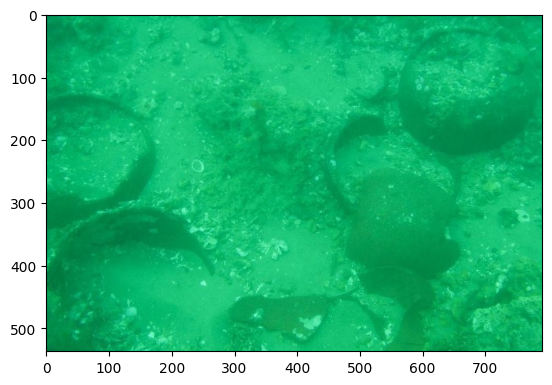

In [5]:
image = cv2.imread(os.path.join(DATASET_PATH, "18_img_.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape :", image.shape )
plt.imshow(image)
plt.show()


As you can see, the image is in shades of green.

Image shape : (480, 640, 3)


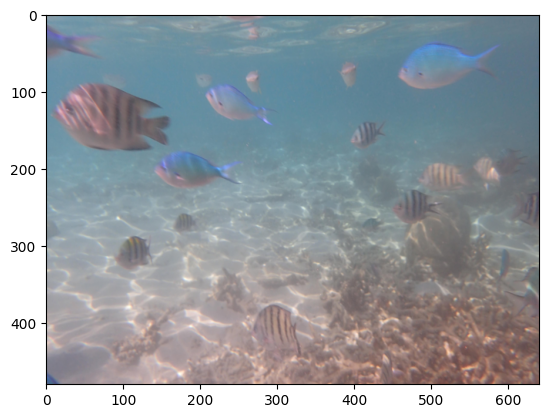

In [6]:
image = cv2.imread(os.path.join(DATASET_PATH, "22_img_.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape :", image.shape )
plt.imshow(image)
plt.show()

As you can see above, there is a haze in the image. As you can see in the examples, we will examine the techniques presented to eliminate these problems.

## Single Image Haze Removal Using Dark Channel Prior[1]
Steps of the algorithm:
1. Compute the dark channel prior of the input hazy image.
2. Estimate the global atmospheric light in the input image.
3. Compute the transmission map of the input image using the dark channel prior and atmo-
spheric light.
4. Remove the haze from the input image using the estimated transmission map and atmospheric light.
5. Clip the pixel values of the output image to the range of [0, 255].

In [15]:
patch_size = (10, 10)
omega = 0.9
rho = 0.12
sigma_s , sigma_r = 5, 0.1
lamb = 1e-4
beta = 0.01

In [17]:
def dark_channel_prior_dehaze(image):
    """
    This function is used for dehazing an image.
    It removes the haze using dark channel prior technique

    :param image: numpy.ndarray
    :return: numpy.ndarray
    """
    # Compute the dark channel prior of the input hazy image.
    kernel = np.ones(patch_size, dtype=np.uint8)
    dark_channel = cv2.erode(np.min(image, axis=2), kernel, iterations=1).astype(np.uint8)

    plt.title("Dark channel")
    plt.imshow(dark_channel, cmap='gray')
    plt.show()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # We first pick the top 0.1 percent brightest pixels in the dark channel
    top_k = 0.01 * dark_channel.shape[0] * dark_channel.shape[1]

    # It returns unique values and their counts
    keys, nums = np.unique(dark_channel, return_counts=True)
    counter = {k: v for k, v in zip(keys, nums)}

    # Among these pixels, the pixels with highest intensity
    # in the input image I are selected as the atmospheric light.
    accum = 0
    candidate = 255
    while candidate >= 0:
        if candidate in counter:
            accum += counter[candidate]
            if accum >= top_k:
                break
        candidate -= 1
    
    # Estimate the global atmospheric light in the input image.
    arg_A = np.argwhere(gray_image == np.max(gray_image[dark_channel >= candidate]))
    atmospheric_light = image[arg_A[0, 0], arg_A[0, 1], :]


    # Compute the transmission map of the input image using 
    # the dark channel prior and atmospheric light.
    image_div_atmos = np.zeros(image.shape, dtype=np.float64)
    for i in range(3):
        image_div_atmos[:, :, i] = image[:, :, i] / atmospheric_light[i]
        
    transmission_map = 1 - omega * cv2.erode(np.min(image_div_atmos, axis=2), kernel, iterations=1)
    plt.title("Transmission Map Before Soft Matting")
    plt.imshow(transmission_map, cmap='gray')
    plt.show()
    # Refine transmission map
    # calculate prior confidence 
    prior_confidence = lamb * np.ones(transmission_map.shape, dtype=np.float64)
    # compute laplacian
    # print("Before laplacian")
    laplacian = compute_laplacian(image)
    print(laplacian.shape)
    # compute confidence
    confidence = scipy.sparse.diags(prior_confidence.ravel())
    print(confidence.shape)
    print("Before solution")
    solution = scipy.sparse.linalg.spsolve(
        laplacian + confidence,
        transmission_map.ravel() * prior_confidence.ravel()
    )
    print("After solution")
    soft_matted_image = np.minimum(np.maximum(solution.reshape(transmission_map.shape), 0), 1)
    refined_transmission_map = cv2.bilateralFilter(soft_matted_image.astype(np.float32), 0, sigma_s, sigma_r)
    refined_transmission_map = np.clip(refined_transmission_map, 0, 1)
    
    # Remove the haze from the input image using the estimated transmission map and atmospheric light.
    output = np.zeros(image.shape, dtype=np.float64)
    for i in range(3):
        output[:, :, i] = (output[:, :, i] - atmospheric_light[i]) / np.maximum(refined_transmission_map, 0.1) + atmospheric_light[i]
    # Clip the pixel values of the output image to the range of [0, 255]
    output = np.clip(output, 0, 255).astype(np.uint8)

    # Calculate scene depth

    depth = -np.log(refined_transmission_map + 1e-8) / beta
    depth_map = np.clip(depth, 0, 255).astype(np.uint8)
    depth_map = cv2.applyColorMap(depth_map, 11)

    return output, refined_transmission_map, depth_map



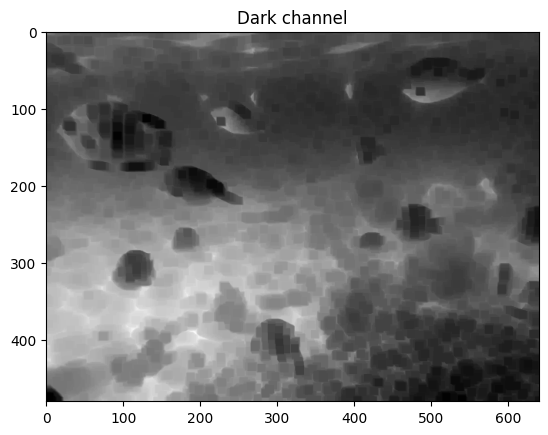

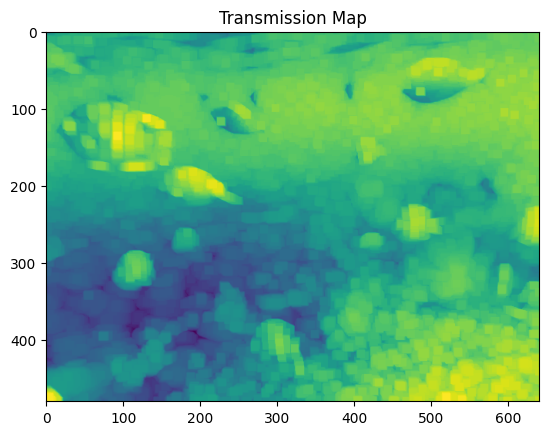

(307200, 307200)
(307200, 307200)
Before solution
After solution


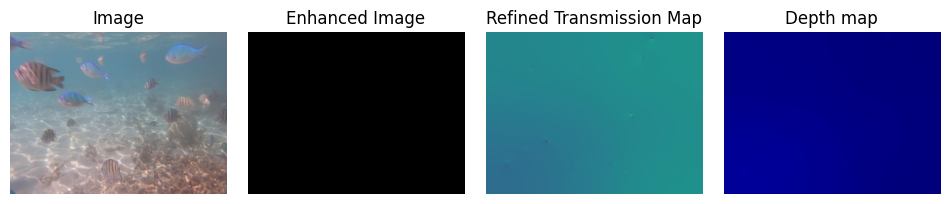

In [18]:
output, refined_transmission_map, depth_map = dark_channel_prior_dehaze(image)
# create a figure
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(output)
axes[1].axis('off')
axes[1].set_title('Enhanced Image')

axes[2].imshow(refined_transmission_map)
axes[2].axis('off')
axes[2].set_title('Refined Transmission Map')

axes[3].imshow(depth_map)
axes[3].axis('off')
axes[3].set_title('Depth map')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# show the figure
plt.show()


## Water-Net[2]
This is a CNN model trained by the UIEB dataset. A gated fusion network called Water-Net fuses the inputs and the predicted confidence maps to produce the improved outcome. The Feature Transformation Units (FTUs) first convert the inputs to the refined inputs before predicting the confidence maps. Finally, by combining the improved inputs and the corresponding confidence maps, the improved result is obtained.

By individually applying White Balance (WB), Histogram Equalization (HE), and Gamma Correction (GC) algorithms to an underwater image, we produce three inputs. In particular, the WB algorithm is used to remove color casts, while the HE and GC algorithms work to boost contrast and brighten dark areas, respectively.


![alt text](assets\Screenshot_1.png)
You can see the Water-Net architecture. 

## Traditional Image Processing Technique[3, 4]
The approach used to enhance underwater images includes color correction, white balancing, contrast enhancement, unsharp masking, and fusion. First, the images are color corrected by compensating for the degradation of the red and blue channels, followed by white balancing using the Gray World algorithm. Then, the contrast of the color-corrected image is enhanced using global histogram equalization, and the image is sharpened using unsharp masking. Finally, two techniques are used for image fusion: averaging-based fusion and PCA-based fusion. The PCA-based fusion involves flattening the components of both images into a column vector, finding the mean, covariance matrix, and eigenvectors of the concatenated matrix, and obtaining the coefficients for each channel for both images to obtain the fused image.


## References
[1] Kaiming He, Jian Sun and Xiaoou Tang, "Single image haze removal using dark channel prior," 2009 IEEE Conference on Computer Vision and Pattern Recognition, Miami, FL, 2009, pp. 1956-1963, doi: 10.1109/CVPR.2009.5206515.
[2] C. Li et al., "An Underwater Image Enhancement Benchmark Dataset and Beyond," in IEEE Transactions on Image Processing, vol. 29, pp. 4376-4389, 2020, doi: 10.1109/TIP.2019.2955241.
[3]Y. Wang, W. Song, G. Fortino, L. Qi, W. Zhang and A. Liotta, "An Experimental-Based Review of Image Enhancement and Image Restoration Methods for Underwater Imaging," in IEEE Access, vol. 7, pp. 140233-140251,2019, doi: 10.1109/ACCESS.2019.2932130.
[4] Weidong Zhang, Lili Dong, Tong Zhang, Wenhai Xu, Enhancing underwater image via color correction and Bi-interval contrast enhancement, Signal Processing: Image Communication, Volume 90, 2021, 116030, ISSN 0923-5965, https://doi.org/10.1016/j.image.2020.116030.